# 2021 Intro. to Machine Learning 
## Program Assignment #2 - Decision Tree & Random Forest & KNN & PCA


### 0816153 陳琮方

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import KFold

In [2]:
# Default settings

PCA_DIMENTION = 5

# Data Input & Preprocessing

先將資料分成 X, Y 

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

data_path = './Dataset/student-mat.csv'
TARGET_LABEL = 'G3'

In [4]:
raw_data = pd.read_csv(data_path, sep = ';')

# Shuffle
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

print(f'Dataset size = {raw_data.shape}\n')

X_raw = raw_data.drop(TARGET_LABEL, axis = 1)
Y_raw = raw_data[TARGET_LABEL]

print(f'X size: {X_raw.shape}')

Dataset size = (395, 33)

X size: (395, 32)


### OneHotEncode

將所有非 Numerical 的 features 做成 OneHotEncode。運用 ```sklearn.preprocessing``` 內的 Encoder。

最後再將 OneHot 完的合併 Numerical 的 feature，可以看到最後 ```X.shape = (395, 58)```

In [5]:
# Binary Features
bin_feat = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 
    'internet', 'romantic'
]

# Nominal Features
cat_feat = [
    'Mjob', 'Fjob', 'reason', 'guardian'           
]

In [6]:
all_feat = bin_feat + cat_feat

onehot_enc = OneHotEncoder(categories = 'auto') # drop='if_binary'
onehot_enc.fit(X_raw[all_feat])

data_array = onehot_enc.transform(X_raw[all_feat]).toarray()
feat_names = onehot_enc.get_feature_names_out(all_feat)

data_frams = pd.DataFrame(data_array, index = X_raw.index, columns = feat_names, dtype = int)

X = pd.concat([X_raw.drop(columns = all_feat), data_frams], axis = 1)

print(f'Number of binary features: {len(bin_feat)}')
print(f'Number of categorical features: {len(cat_feat)}')
print(f' => Sum of unique categorical: {len(feat_names)}')

print('\n=====================================')
print(f'X size after one-hot: {X.shape}')

Number of binary features: 13
Number of categorical features: 4
 => Sum of unique categorical: 43

X size after one-hot: (395, 58)


### Other Preprocessing

- Binary classification - pass if G3 ≥ 10, else fail.
- 5-Level classification - based on the Erasmus grad conversion system.


|G3   | 16-20  | 14-15  | 12-13  |  10-11 |   0-9  |
|-----|--------|--------|--------|--------|--------|
|Rank |    A   |    B   |    C   |    D   |    F   |

In [7]:
Y_bin = []
Y_5lv = []

for i in Y_raw:
    Y_bin.append((1 if i >= 10 else 0))
    if i >= 16: Y_5lv.append('A'); continue;
    if i >= 14: Y_5lv.append('B'); continue;
    if i >= 12: Y_5lv.append('C'); continue;
    if i >= 10: Y_5lv.append('D'); continue;
    Y_5lv.append('F')
    
Y_bin = np.array(Y_bin)
Y_5lv = np.array(Y_5lv)

#### GetAve

算 K-fold 的 Ave. Result

In [8]:
def getAve(result):
    n = len(result)

    for i in range(1, len(result)):
        result[0]['Accuracy'] += result[i]['Accuracy']
        result[0]['Confusion Matrix'] += result[i]['Confusion Matrix']
        result[0]['Recall'] += result[i]['Recall']
        result[0]['Precision'] += result[i]['Precision']

    result[0]['Accuracy'] /= 3
    result[0]['Confusion Matrix'] = np.round(np.divide(result[0]['Confusion Matrix'],3), 2)
    result[0]['Recall'] /= 3
    result[0]['Precision'] /= 3
    
    result[0]['Recall'] = np.round(result[0]['Recall'], 4)
    result[0]['Precision'] = np.round(result[0]['Precision'], 4)
    
    return result[0]

# Principal Components Analysis (PCA)

### PCA Eigenvectors and Eigenvalues of cov(x)

cov(x) = QΛQT

這裡運用 ```sklearn``` 內的 ```decomposition.PCA``` 
會將 OneHot encode 的拔掉，對於其他 Numerical 的做 PCA 降維，再合併一起。
本次作業我會將 15 個 numerical 將為 ```PCA_DIMENTION = 5```。

In [9]:
from sklearn import decomposition

def pca_analy(X, pca_dim = PCA_DIMENTION):
    pca = decomposition.PCA(n_components = pca_dim)
    pca.fit(X)
    
    return pca

In [10]:
from numpy import linalg as LA

def toPCA(now_X, pca = None, dim = PCA_DIMENTION):
    drp_X = now_X.drop(feat_names, axis = 1)
    now_X = now_X[feat_names]
    
    if pca == None:
        pca = pca_analy(drp_X, dim)
    
    now_X = np.concatenate([now_X.to_numpy(), pca.transform(drp_X)], axis = 1)
    
    return now_X, pca

# Model Construction

In [11]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

def getResult(y_test, y_pred):
    ret = {}
    
    ret['Accuracy'] = accuracy_score(y_test, y_pred)
    ret['Recall'] = recall_score(y_test, y_pred, average='micro')
    ret['Precision'] = precision_score(y_test, y_pred, average='micro')
    ret['Confusion Matrix'] = confusion_matrix(y_test, y_pred)
    
    return ret

## Decision Tree

這裡採用 ```sklearn.tree``` 中的 ```DecisionTreeClassifier```，可以在下方表格看到結果。
在只有兩種分類的時候結果還不錯，加上 PCA 也略提升準確率（但測試的時後不一定都是正向影響）。
當提升到五種分類的時候，準確率大大將低，也是預期之中的事。

In [12]:
from sklearn.tree import DecisionTreeClassifier

def decisionTree(X, Y, pca = False):
    kf = KFold(n_splits = 3, shuffle = True)
    
    result = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        if pca == True:
            X_train, pca = toPCA(X_train)
            X_test       = toPCA(X_test, pca)[0]
        
        clf = DecisionTreeClassifier(random_state = 0)
        clf.fit(X_train, Y_train)

        y_pred = clf.predict(X_test)
        ret = getResult(Y_test, y_pred)
        result.append(ret)
    
    return getAve(result)

In [13]:
result = {}

result['DT Binary'] = decisionTree(X, Y_bin)
result['DT Binary PCA'] = decisionTree(X, Y_bin, pca = True)

result['DT 5-lv'] = decisionTree(X, Y_5lv)
result['DT 5-lv PCA'] = decisionTree(X, Y_5lv, pca = True)

pd.options.display.max_colwidth = 80
df = pd.DataFrame.from_dict(result, orient = 'index')
df

,Accuracy,Recall,Precision,Confusion Matrix
DT Binary,0.878422,0.8784,0.8784,"[[35.33, 8.0], [8.0, 80.33]]"
DT Binary PCA,0.881024,0.8810,0.8810,"[[34.67, 8.67], [7.0, 81.33]]"
DT 5-lv,0.635361,0.6354,0.6354,"[[9.33, 3.33, 0.67, 0.0, 0.0], [4.0, 12.0, 4.0, 0.0, 0.0], [0.0, 5.33, 9.33,..."
DT 5-lv PCA,0.630311,0.6303,0.6303,"[[8.33, 5.0, 0.0, 0.0, 0.0], [3.67, 12.33, 4.0, 0.0, 0.0], [0.0, 2.33, 11.67..."


## Random Forest

這裡也是採用 ```sklearn.ensemble``` 中的 ```RandomForestClassifier```，並分別測試了 n_tree = 20, 40, 80 ，可以在下方表格看到結果。

增加樹的數量可以增加準確度，但還是會有上限，可以看到 40 顆跟 80 對比 20 顆都有提升，但 40 跟 80 就不一定。另外，PCA 的成效也有負有正，需要測是多一點數據可能會有比較好的選擇。

In [14]:
from sklearn.ensemble import RandomForestClassifier

def randomForest(X, Y, max_dep = None, n_tree = 10, pca = False):
    kf = KFold(n_splits=3, shuffle = True)
    
    result = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        if pca == True:
            X_train, pca = toPCA(X_train)
            X_test       = toPCA(X_test, pca)[0]
        
        clf = RandomForestClassifier(n_estimators=n_tree, max_depth=max_dep, random_state=0)
        clf.fit(X_train, Y_train)
    
        y_pred = clf.predict(X_test)
        ret = getResult(Y_test, y_pred)
        result.append(ret)
    
    return getAve(result)

In [15]:
result = {}

# Binary
result['RF-20 Binary'] = randomForest(X, Y_bin, max_dep = None, n_tree = 20)
result['RF-20 Binary PCA'] = randomForest(X, Y_bin, max_dep = None, n_tree = 20, pca = True)

result['RF-40 Binary'] = randomForest(X, Y_bin, max_dep = None, n_tree = 40)
result['RF-40 Binary PCA'] = randomForest(X, Y_bin, max_dep = None, n_tree = 40, pca = True)

result['RF-80 Binary'] = randomForest(X, Y_bin, max_dep = None, n_tree = 80)
result['RF-80 Binary PCA'] = randomForest(X, Y_bin, max_dep = None, n_tree = 80, pca = True)

# 5-Level
result['RF-20 5lv'] = randomForest(X, Y_5lv, max_dep = None, n_tree = 20)
result['RF-20 5lv PCA'] = randomForest(X, Y_5lv, max_dep = None, n_tree = 20, pca = True)

result['RF-40 5lv'] = randomForest(X, Y_5lv, max_dep = None, n_tree = 40)
result['RF-40 5lv PCA'] = randomForest(X, Y_5lv, max_dep = None, n_tree = 40, pca = True)

result['RF-80 5lv'] = randomForest(X, Y_5lv, max_dep = None, n_tree = 80)
result['RF-80 5lv PCA'] = randomForest(X, Y_5lv, max_dep = None, n_tree = 80, pca = True)

pd.options.display.max_colwidth = 80
df = pd.DataFrame.from_dict(result, orient = 'index')
df

,Accuracy,Recall,Precision,Confusion Matrix
RF-20 Binary,0.888696,0.8887,0.8887,"[[36.33, 7.0], [7.67, 80.67]]"
RF-20 Binary PCA,0.886152,0.8862,0.8862,"[[35.67, 7.67], [7.33, 81.0]]"
RF-40 Binary,0.911385,0.9114,0.9114,"[[37.67, 5.67], [6.0, 82.33]]"
RF-40 Binary PCA,0.908937,0.9089,0.9089,"[[36.33, 7.0], [5.0, 83.33]]"
RF-80 Binary,0.906373,0.9064,0.9064,"[[37.0, 6.33], [6.0, 82.33]]"
RF-80 Binary PCA,0.888658,0.8887,0.8887,"[[36.0, 7.33], [7.33, 81.0]]"
RF-20 5lv,0.642918,0.6429,0.6429,"[[6.67, 6.33, 0.33, 0.0, 0.0], [2.67, 10.67, 4.0, 2.67, 0.0], [0.33, 4.67, 7..."
RF-20 5lv PCA,0.599988,0.6000,0.6000,"[[7.67, 4.33, 1.33, 0.0, 0.0], [4.33, 10.67, 2.33, 2.0, 0.67], [0.67, 5.0, 6..."
RF-40 5lv,0.658301,0.6583,0.6583,"[[7.0, 6.33, 0.0, 0.0, 0.0], [2.33, 14.33, 2.67, 0.67, 0.0], [0.0, 4.0, 7.33..."
RF-40 5lv PCA,0.660807,0.6608,0.6608,"[[6.0, 6.0, 0.67, 0.33, 0.33], [2.67, 13.33, 2.67, 1.0, 0.33], [0.33, 4.0, 8..."


## K-Nearest Neighbor

這裡我使用 KNN ，並把 n = 10, 20, 40 下去試試看。結果都與上面兩種方法類似。
5lv : 5-level classification
bin : Binary classification

In [16]:
from sklearn.neighbors import KNeighborsClassifier

def knn(X, Y, n = 3, pca = False):
    kf = KFold(n_splits=3, shuffle = True)
    
    result = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        if pca == True:
            X_train, pca = toPCA(X_train)
            X_test       = toPCA(X_test, pca)[0]
        
        neigh = KNeighborsClassifier(n_neighbors=n)
        neigh.fit(X_train, Y_train)

        y_pred = neigh.predict(X_test)
        ret = getResult(Y_test, y_pred)
        result.append(ret)
        
    return getAve(result)

In [17]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

result = {}

# Binary
result['KNN-10 Binary'] = knn(X, Y_bin, 10)
result['KNN-10 Binary PCA'] = knn(X, Y_bin, 10, pca = True)

result['KNN-20 Binary'] = knn(X, Y_bin, 20)
result['KNN-20 Binary PCA'] = knn(X, Y_bin, 20, pca = True)

result['KNN-40 Binary'] = knn(X, Y_bin, 40)
result['KNN-40 Binary PCA'] = knn(X, Y_bin, 40, pca = True)

# 5-Level
result['KNN-10 5lv'] = knn(X, Y_5lv, 10)
result['KNN-10 5lv PCA'] = knn(X, Y_5lv, 10, pca = True)

result['KNN-20 5lv'] = knn(X, Y_5lv, 20)
result['KNN-20 5lv PCA'] = knn(X, Y_5lv, 20, pca = True)

result['KNN-40 5lv'] = knn(X, Y_5lv, 40)
result['KNN-40 5lv PCA'] = knn(X, Y_5lv, 40, True)

pd.options.display.max_colwidth = 80
df = pd.DataFrame.from_dict(result, orient = 'index')
df

,Accuracy,Recall,Precision,Confusion Matrix
KNN-10 Binary,0.886074,0.8861,0.8861,"[[36.0, 7.33], [7.67, 80.67]]"
KNN-10 Binary PCA,0.873410,0.8734,0.8734,"[[35.67, 7.67], [9.0, 79.33]]"
KNN-20 Binary,0.863251,0.8633,0.8633,"[[32.0, 11.33], [6.67, 81.67]]"
KNN-20 Binary PCA,0.893708,0.8937,0.8937,"[[35.33, 8.0], [6.0, 82.33]]"
KNN-40 Binary,0.863309,0.8633,0.8633,"[[29.0, 14.33], [3.67, 84.67]]"
KNN-40 Binary PCA,0.863232,0.8632,0.8632,"[[30.0, 13.33], [4.67, 83.67]]"
KNN-10 5lv,0.650667,0.6507,0.6507,"[[5.33, 7.33, 0.67, 0.0, 0.0], [1.67, 16.67, 1.33, 0.33, 0.0], [0.0, 6.67, 6..."
KNN-10 5lv PCA,0.604962,0.6050,0.6050,"[[7.33, 5.33, 0.67, 0.0, 0.0], [1.33, 16.0, 1.67, 1.0, 0.0], [0.0, 5.67, 5.3..."
KNN-20 5lv,0.655717,0.6557,0.6557,"[[6.33, 6.33, 0.67, 0.0, 0.0], [0.67, 16.67, 1.33, 1.33, 0.0], [0.0, 5.33, 5..."
KNN-20 5lv PCA,0.663390,0.6634,0.6634,"[[6.0, 6.67, 0.67, 0.0, 0.0], [0.33, 17.67, 0.67, 1.33, 0.0], [0.0, 5.33, 6...."


# Question

## Q1. Decision Tree
### Show the prediction and reasoning of one arbitrary sample in the testing set

建造一個模型，重 Testing set 抓一個數據當 Tersting ，運用 ```tree.plot_tree``` 將 DT 的分類畫出來，再根據資料往左往右走，看預測結果。

(有用到 Random ，所以每次跑的數據都不一樣)

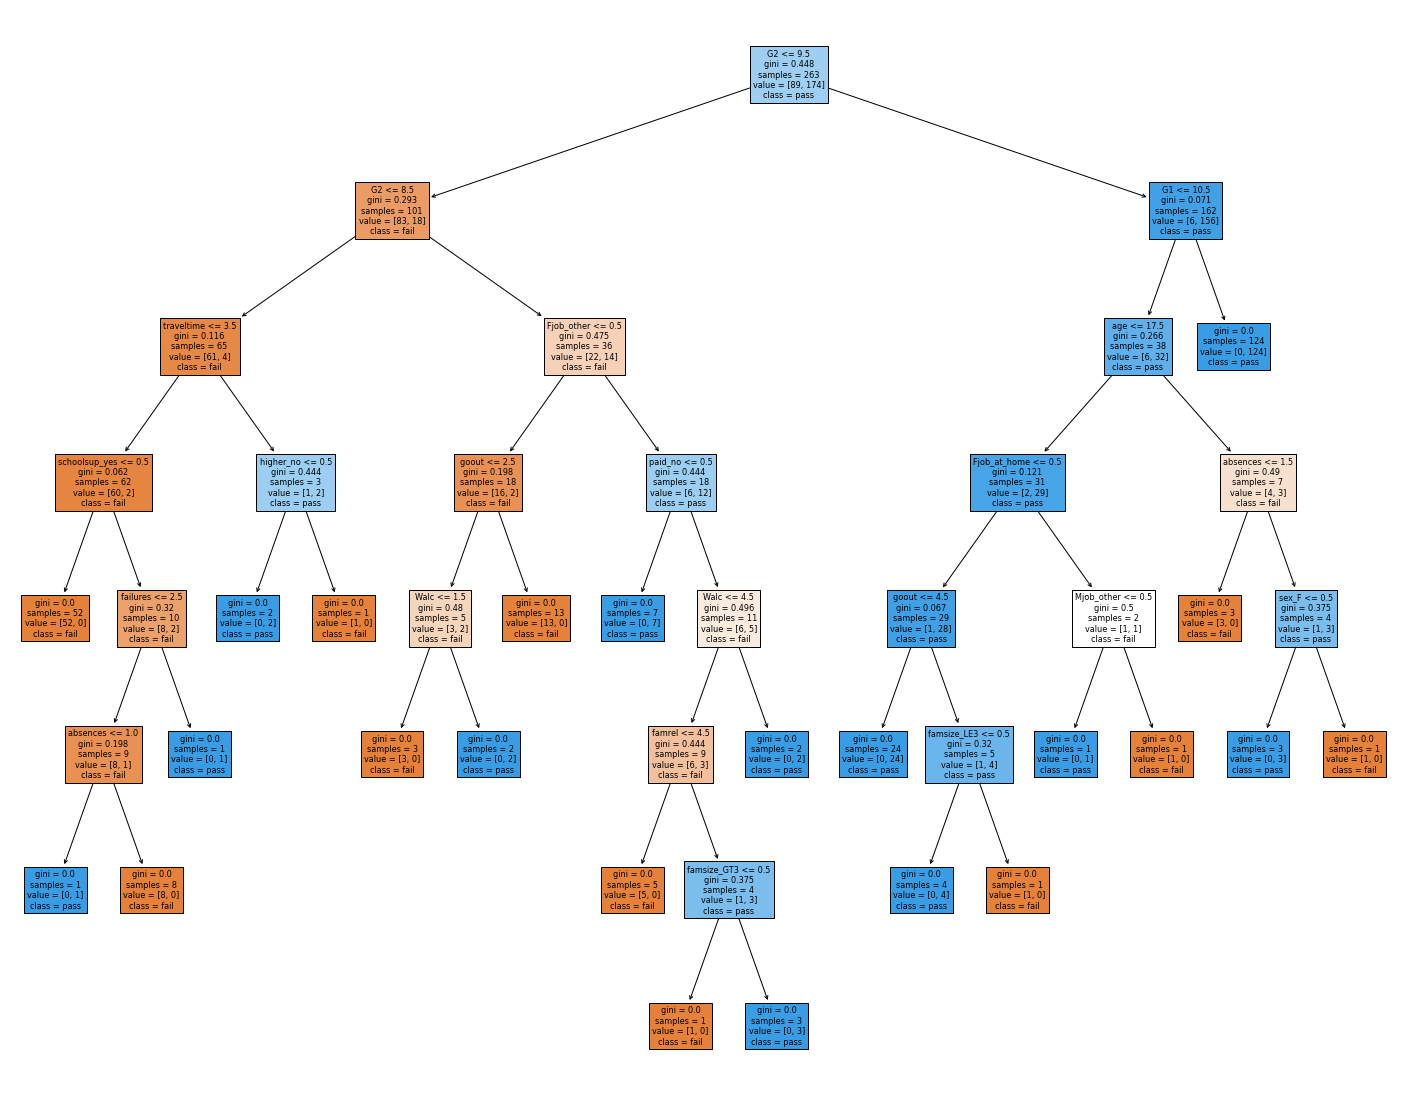

In [18]:
from sklearn import tree

kf = KFold(n_splits = 3, shuffle = True)

test_x = None
test_y = None
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y_bin[train_index], Y_bin[test_index]
    
    test_x = X_test.iloc[0]
    test_y = Y_test[0]
    clf = DecisionTreeClassifier(random_state = 0)
    clf.fit(X_train, Y_train)
    break
    
# print(f'X = \n{test_x}')
# print(f'\nY = {test_y} (Correct)')
# print(f'Predict = {clf.predict([test_x])}')

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names= X.columns, 
                   class_names=["fail", "pass"], filled=True)

### Example
#### Testcase:
```
X = 
age                  17
traveltime            2
studytime             2
G1                   10
G2                    9
schoolsup_no          1
Mjob_teacher          1
Name: 6, dtype: int64
```
#### Result
```
Y = 0 (Correct)
Predict = [1]
```

![](https://i.imgur.com/8Kx55XN.png)

上面即為一個預測錯誤的 data (from testing set)

## Q2. Random Forest
### Describe the difference between boosting and bagging.

- Boosting
一個個分類互相關係，第一個模型錯誤的資料會加大權重丟到第二個去訓練，第二個錯誤的加大權重放到第三個去訓練，最後再根據每一個模型的結果，用 Majority Vote 決定。


- Bagging
Bagging 會從訓練資料中隨機抽取，然後訓練多個分類模型，最終結果用 Majority Vote 決定。

#### 所以兩者最大差別為若有 Noise 的 data ，對於 Bagging 影響小，但 Boostring 影響大（容易 Overfit)

## Q3. KNN
### Show the prediction and reasoning of one arbitrary sample in the testing set

我這邊與上面相同方法，取一組數據，看他與訓練資料中最相近的 k (k = 10) 個點的距離，然後根據這 k 個點的分類，用 Majority vote 的方法決定預測值。

#### Testcase:
```
age                  17
Medu                  2
Fedu                  2
traveltime            1
studytime             2
failures              0
famrel                5
freetime              4
goout                 5
Dalc                  1
Walc                  2
health                5
absences              4
G1                   10
G2                    9
school_GP             1
school_MS             0
sex_F                 1
sex_M                 0
address_R             0
address_U             1
famsize_GT3           1
famsize_LE3           0
Pstatus_A             0
Pstatus_T             1
schoolsup_no          1
schoolsup_yes         0
famsup_no             0
famsup_yes            1
paid_no               1
paid_yes              0
activities_no         1
activities_yes        0
nursery_no            1
nursery_yes           0
higher_no             0
higher_yes            1
internet_no           0
internet_yes          1
romantic_no           1
romantic_yes          0
Mjob_at_home          0
Mjob_health           0
Mjob_other            1
Mjob_services         0
Mjob_teacher          0
Fjob_at_home          0
Fjob_health           0
Fjob_other            1
Fjob_services         0
Fjob_teacher          0
reason_course         1
reason_home           0
reason_other          0
reason_reputation     0
guardian_father       0
guardian_mother       1
guardian_other        0
Name: 2, dtype: int64
```

#### Result
```
distant of nearst 10 node = [0.0, 4.36, 4.47, 4.58, 4.58, 4.58, 4.58, 5.0, 5.0, 5.1]
label = [1, 1, 1, 1, 1, 1, 0, 0, 1, 0]

=============================================
1(PASS): 7, 0(FAIL): 3
 => So the prediction is = [1]
```
根據上面，所以最近 k 的點的分類中有 7 個 PASS， 1 個 Fail，所以預測結果是 PASS.

In [19]:
X_now = X
Y_now = Y_bin

kf = KFold(n_splits = 3, shuffle = True)
k = 10

test_x = None
test_y = None
for train_index, test_index in kf.split(X):
    X_train, X_test = X_now.iloc[train_index], X_now.iloc[test_index]
    Y_train, Y_test = Y_now[train_index], Y_now[test_index]
    
    test_x = X_test.iloc[0]
    test_y = Y_test[0]
    
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(X_now, Y_now)
    break

dis = neigh.kneighbors([test_x])
prd = neigh.predict([test_x])

distances = np.round(dis[0][0], 2).tolist()
labels = Y_bin[dis[1][0]].tolist()

print(test_x)
print('\n=============================================\n')
print(f'distant of nearst {k} node = {distances}')
print(f'label = {labels}')
print('\n=============================================')
print(f'1(PASS): {labels.count(1)}, 0(FAIL): {labels.count(0)}')
print(f' => So the prediction is = {prd}')

age                  19
Medu                  1
Fedu                  1
traveltime            2
studytime             1
failures              1
famrel                4
freetime              3
goout                 2
Dalc                  1
Walc                  3
health                5
absences              0
G1                    6
G2                    5
school_GP             0
school_MS             1
sex_F                 0
sex_M                 1
address_R             1
address_U             0
famsize_GT3           1
famsize_LE3           0
Pstatus_A             0
Pstatus_T             1
schoolsup_no          1
schoolsup_yes         0
famsup_no             1
famsup_yes            0
paid_no               1
paid_yes              0
activities_no         1
activities_yes        0
nursery_no            0
nursery_yes           1
higher_no             0
higher_yes            1
internet_no           1
internet_yes          0
romantic_no           1
romantic_yes          0
Mjob_at_home    

### Pick 2 features, draw and describe the KNN decision boundaries

我覺得最有效且直接影響的就是他的 G1, G2 socre ，所以我用這兩的數據畫出關係圖，可以發現確實可以將人容易的分出兩部份，只有在邊緣徘徊的有可能會預測錯誤，結果非常合理。

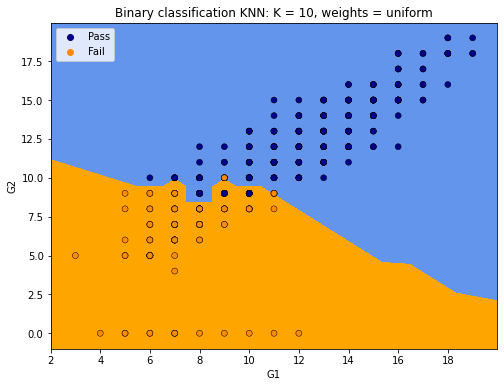

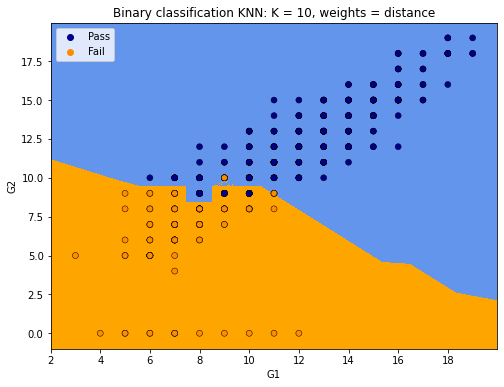

In [20]:
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA


X_now = X[['G1', 'G2']].to_numpy()
Y_now = Y_bin

h = 0.02 # step size in mesh

cmap_light = ListedColormap(["orange", "cornflowerblue"])
cmap_bold = {"Fail" : "darkorange", "Pass" : "darkblue"}

for weights in ["uniform", "distance"]:
    clf = KNeighborsClassifier(n_neighbors = 10, weights = weights)
    clf.fit(X_now, Y_now)

    x_min, x_max = X_now[:, 0].min() - 1, X_now[:, 0].max() + 1
    y_min, y_max = X_now[:, 1].min() - 1, X_now[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(
        x = X_now[:, 0],
        y = X_now[:, 1],
        hue = ["Pass" if i == 1 else "Fail" for i in Y_now],
        palette = cmap_bold,
        alpha = 1.0,
        edgecolor = "black",
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        f'Binary classification KNN: K = {10}, weights = {weights}'
    )
    plt.xlabel('G1')
    plt.ylabel('G2')

## Q4. PCA
### In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels

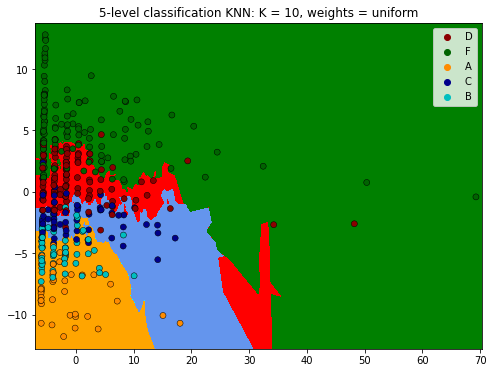

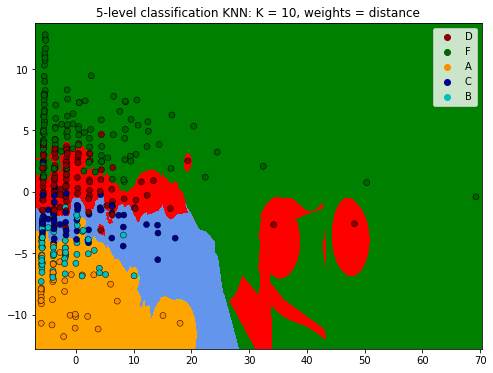

In [21]:
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)

X_now = pca.transform(X)
Y_now = Y_5lv

h = 0.02 # step size in mesh

cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue", "red", "green"])
cmap_bold = {
    "A" : "darkorange", 
    "B" : "c", 
    "C" : "darkblue",
    "D" : "darkred", 
    "F" : "darkgreen"
}

for weights in ["uniform", "distance"]:
    clf = KNeighborsClassifier(n_neighbors = 10, weights = weights)
    clf.fit(X_now, Y_now)

    x_min, x_max = X_now[:, 0].min() - 1, X_now[:, 0].max() + 1
    y_min, y_max = X_now[:, 1].min() - 1, X_now[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    for i in range(len(Z)):
        if Z[i] == 'A': Z[i] = 0; 
        if Z[i] == 'B': Z[i] = 1;
        if Z[i] == 'C': Z[i] = 2; 
        if Z[i] == 'D': Z[i] = 3;
        if Z[i] == 'F': Z[i] = 4;
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(
        x = X_now[:, 0],
        y = X_now[:, 1],
        hue = Y_now,
        palette = cmap_bold,
        alpha = 1.0,
        edgecolor = "black",
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        f'5-level classification KNN: K = {10}, weights = {weights}'
    )